In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import lightgbm as lgb
import numpy as np
import xgboost
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import datetime
from scipy.stats import boxcox


# import h2o

# from h2o.automl import H2OAutoML
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space

In [3]:
data = pd.read_csv(
    "../data/processed/data.csv", parse_dates=["date_forecast", "date_calc"]
)

# Modeling Notebook


Each model returns is trained on a subset of the data. The models are then combined into a voting classifier. The voting classifier is then used to predict the test data.


In [6]:
result = {}
test_result = {}

In [5]:
def scale_data(data, cols=None):
    if cols is None:
        ignore_cols = [
            "location",
            "dew_or_rime:idx",
            "is_day:idx",
            "is_in_shadow:idx",
            "pv_measurement",
            "data_type",
        ]

        cols = [col for col in data.columns if col not in ignore_cols]

    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][cols]
    )
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][["pv_measurement"]]
    )

    data_copy = data.copy()

    data_copy[cols] = X_scaler.transform(data_copy[cols])
    data_copy[["pv_measurement"]] = y_scaler.transform(data[["pv_measurement"]])

    return data_copy, X_scaler, y_scaler

## 1. General Model – Catboost (MAE)


### Feature Engineering and Selection


In [201]:
data_general_catboost_mae = data.copy()


# Drop columns that are not needed
drop_cols = [
    # "cloud_base_agl:m",
    # "ceiling_height_agl:m",
    # "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "sun_azimuth:d",
]
data_general_catboost_mae = data_general_catboost_mae.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [col for col in data_general_catboost_mae.columns if col not in ignore_cols]

data_general_catboost_mae, _, y_scaler = scale_data(
    data_general_catboost_mae, cols=cols
)

# Create training and test data
train = (
    data_general_catboost_mae[
        data_general_catboost_mae["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_mae[data_general_catboost_mae["data_type"] == "test"]
    .drop(columns=["data_type"])
    .copy()
)

### Model Setup


In [202]:
# ---------------------------- CATBOOST ----------------------------


# Create the CatBoost model
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="MAE")

# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=42)

result["general_catboost_mae"] = pd.DataFrame()

temp_test_result = []
temp_test_indices = []

# # Perform k-fold cross-validation
for train_index, validation_index in kFold.split(train):
    print(f"Train Index: {train_index}, Validation Index: {validation_index}")

    fold_train, fold_validation = train.iloc[train_index], train.iloc[validation_index]

    pool_train = catboost.Pool(
        data=fold_train[
            [
                column
                for column in fold_train.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=fold_train[["pv_measurement"]],
    )
    pool_validation = catboost.Pool(
        data=fold_validation[
            [
                column
                for column in fold_validation.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=fold_validation[["pv_measurement"]],
    )

    # Fit the CatBoost model on the training data
    model.fit(
        pool_train,
        verbose=False,
    )

    # Make predictions on the validation data
    predictions = y_scaler.inverse_transform(
        model.predict(pool_validation).reshape(-1, 1)
    )

    result["general_catboost_mae"] = pd.concat(
        [
            result["general_catboost_mae"],
            pd.DataFrame(predictions, index=validation_index),
        ],
        axis=0,
    )

    # Make prediction on the test data
    pool_test = catboost.Pool(
        data=test[
            [column for column in test.columns if not column in ["pv_measurement"]]
        ],
        cat_features=["location"],
        label=test[["pv_measurement"]],
    )

    temp_test_result.append(
        y_scaler.inverse_transform(model.predict(pool_test).reshape(-1, 1))
    )


test_result["general_catboost_mae"] = pd.DataFrame(
    np.mean(temp_test_result, axis=0), index=test.index
)
result["general_catboost_mae"] = result["general_catboost_mae"].sort_index()

Train Index: [    0     1     2 ... 83042 83043 83044], Validation Index: [   24    35    39 ... 83032 83033 83041]
Train Index: [    0     1     2 ... 83042 83043 83044], Validation Index: [    4     6     7 ... 83020 83034 83038]
Train Index: [    2     4     5 ... 83041 83043 83044], Validation Index: [    0     1     3 ... 83019 83035 83042]
Train Index: [    0     1     2 ... 83040 83041 83042], Validation Index: [    8    14    16 ... 83039 83043 83044]
Train Index: [    0     1     3 ... 83042 83043 83044], Validation Index: [    2     5    15 ... 83031 83036 83040]


### Model Result


In [203]:
mean_absolute_error(
    result["general_catboost_mae"][0].sort_index(), train["pv_measurement"].sort_index()
)

308.54977596349534

## 1. General Model – Catboost (RSME)


### Feature Engineering and Selection


In [204]:
data_general_catboost_RMSE = data.copy()

# Drop columns that are not needed
drop_cols = [
    # "cloud_base_agl:m",
    # "ceiling_height_agl:m",
    # "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "sun_azimuth:d",
]
data_general_catboost_RMSE = data_general_catboost_RMSE.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [col for col in data_general_catboost_RMSE.columns if col not in ignore_cols]

data_general_catboost_RMSE, _, y_scaler = scale_data(
    data_general_catboost_RMSE, cols=cols
)

# Create training and test data
train = (
    data_general_catboost_RMSE[
        data_general_catboost_RMSE["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_RMSE[data_general_catboost_RMSE["data_type"] == "test"]
    .drop(columns=["data_type"])
    .copy()
)

### Model Setup


In [205]:
# ---------------------------- CATBOOST ----------------------------


# Create the CatBoost model
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="RMSE")

# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=56)

result["general_catboost_rmse"] = pd.DataFrame()

temp_test_result = []
temp_test_indices = []

# # Perform k-fold cross-validation
for train_index, validation_index in kFold.split(train):
    print(f"Train Index: {train_index}, Validation Index: {validation_index}")

    fold_train, fold_validation = train.iloc[train_index], train.iloc[validation_index]

    pool_train = catboost.Pool(
        data=fold_train[
            [
                column
                for column in fold_train.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=fold_train[["pv_measurement"]],
    )
    pool_validation = catboost.Pool(
        data=fold_validation[
            [
                column
                for column in fold_validation.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=fold_validation[["pv_measurement"]],
    )

    # Fit the CatBoost model on the training data
    model.fit(
        pool_train,
        verbose=False,
    )

    # Make predictions on the validation data
    predictions = y_scaler.inverse_transform(
        model.predict(pool_validation).reshape(-1, 1)
    )

    result["general_catboost_rmse"] = pd.concat(
        [
            result["general_catboost_rmse"],
            pd.DataFrame(predictions, index=validation_index),
        ],
        axis=0,
    )

    # Make prediction on the test data
    pool_test = catboost.Pool(
        data=test[
            [column for column in test.columns if not column in ["pv_measurement"]]
        ],
        cat_features=["location"],
        label=test[["pv_measurement"]],
    )

    temp_test_result.append(
        y_scaler.inverse_transform(model.predict(pool_test).reshape(-1, 1))
    )


test_result["general_catboost_rmse"] = pd.DataFrame(
    np.mean(temp_test_result, axis=0), index=test.index
)
result["general_catboost_rmse"] = result["general_catboost_rmse"].sort_index()

Train Index: [    0     1     2 ... 83040 83041 83043], Validation Index: [    7     9    13 ... 83033 83042 83044]
Train Index: [    0     2     3 ... 83041 83042 83044], Validation Index: [    1     4     8 ... 83038 83039 83043]
Train Index: [    0     1     2 ... 83042 83043 83044], Validation Index: [    5     6    21 ... 83010 83017 83023]
Train Index: [    1     2     3 ... 83042 83043 83044], Validation Index: [    0    11    15 ... 83031 83034 83040]
Train Index: [    0     1     4 ... 83042 83043 83044], Validation Index: [    2     3    10 ... 83036 83037 83041]


### Model Result


In [65]:
mean_absolute_error(
    result["general_catboost_rmse"][0].sort_index(),
    train["pv_measurement"].sort_index(),
)

KeyError: 'general_catboost_rmse'

## 1. General Model – LightGBM


### Feature Engineering and Selection


In [139]:
data_general_lgb = data.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour_sin",
    "hour_cos",
    "month_cos",
    "month_sin",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    "date_forecast",
]

data_general_lgb = data_general_lgb.drop(drop_cols, axis=1)
data_general_lgb.columns = [
    column.replace(":", "_") for column in data_general_lgb.columns
]

ignore_cols = [
    "location",
    "is_day_idx",
    "is_in_shadow_idx",
    "pv_measurement",
    "data_type",
]

data_general_lgb["is_day_idx"] = data_general_lgb["is_day_idx"].astype("int")
data_general_lgb["is_in_shadow_idx"] = data_general_lgb["is_in_shadow_idx"].astype("int")
data_general_lgb["dew_or_rime_idx"] = data_general_lgb["dew_or_rime_idx"].astype("int")

cols = [col for col in data_general_lgb.columns if col not in ignore_cols]


data_general_lgb, _, y_scaler = scale_data(data_general_lgb, cols=cols)

# Create training and test data
test = data_general_lgb[data_general_lgb["data_type"].isin(["test"])].copy()
train, val = (
    data_general_lgb[data_general_lgb["data_type"].isin(["observed", "estimated"])][
        : int(
            len(
                data_general_lgb[
                    data_general_lgb["data_type"].isin(["observed", "estimated"])
                ]
            )
            * 0.99
        )
    ].copy(),
    data_general_lgb[data_general_lgb["data_type"].isin(["observed", "estimated"])][
        int(
            len(
                data_general_lgb[
                    data_general_lgb["data_type"].isin(["observed", "estimated"])
                ]
            )
            * 0.99
        ) :
    ].copy(),
)

In [103]:
y_scaler.inverse_transform(val[["pv_measurement"]]).shape

(831, 1)

### Model Setup


In [144]:
# ------------------------- LIGHTGBM ----------------------------

# Create the LightGBM dataset
train_data = lgb.Dataset(train, label=train[["pv_measurement"]])

# Create the LightGBM parameters
params = {
    "A": {
        "objective": "regression",
        "lambda_l1": 2.669782558931761e-05,
        "lambda_l2": 5.7419524221393384e-06,
        "num_leaves": 71,
        "feature_fraction": 0.40204451270311864,
        "bagging_fraction": 0.494903586208577,
        "bagging_freq": 1,
        "min_child_samples": 18,
    },
    "B": {
        "lambda_l1": 0.0005807666539722544,
        "lambda_l2": 1.1302231537307642e-05,
        "num_leaves": 41,
        "feature_fraction": 0.40654110855708514,
        "bagging_fraction": 0.899371616619721,
        "bagging_freq": 2,
        "min_child_samples": 36,
    },
    "C": {
        "lambda_l1": 0.43708693569090734,
        "lambda_l2": 7.022986221584428e-05,
        "num_leaves": 199,
        "feature_fraction": 0.6099817663711093,
        "bagging_fraction": 0.7083302032339568,
        "bagging_freq": 3,
        "min_child_samples": 28,
    },
}
num_boost_round = 1000  # Adjust if needed

result["general_lightgbm"] = pd.DataFrame()
test_result["general_lightgbm"] = pd.DataFrame()

temp_test_result = []
temp_test_indices = []

for location in ("A", "B", "C"):
    train_loc = train[train["location"] == location].drop(
        columns=["location", "data_type"]
    )
    val_loc = val[val["location"] == location].drop(columns=["location", "data_type"])

    # Create the LightGBM dataset
    train_data = lgb.Dataset(
        train_loc.drop(columns="pv_measurement"),
        label=train_loc[["pv_measurement"]],
        categorical_feature=["is_day_idx", "is_in_shadow_idx"],
    )
    val_data = lgb.Dataset(
        val_loc.drop(columns="pv_measurement"),
        label=val_loc[["pv_measurement"]],
        categorical_feature=["is_day_idx", "is_in_shadow_idx"],
    )

    # Train the LightGBM model
    model = lgb.train(
        params[location],
        train_data,
        # num_boost_round=num_boost_round,
        verbose_eval=False,
    )

    # Make predictions on the validation data
    predictions = y_scaler.inverse_transform(
        model.predict(val_loc.drop(columns="pv_measurement")).reshape(-1, 1)
    )
    # Make predictions on the validation data
    predictions_test = y_scaler.inverse_transform(
        model.predict(
            test[test["location"] == location].drop(
                columns=["location", "data_type", "pv_measurement"]
            )
        ).reshape(-1, 1)
    )

    result["general_lightgbm"] = pd.concat(
        [
            result["general_lightgbm"],
            pd.DataFrame(predictions, index=val_loc.index),
        ],
        axis=0,
    )
    test_result["general_lightgbm"] = pd.concat(
        [
            test_result["general_lightgbm"],
            pd.DataFrame(predictions_test),
        ],
        axis=0,
    )


result["general_lightgbm"] = result["general_lightgbm"].sort_index()

/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7365
[LightGBM] [Info] Number of data points in the train set: 33784, number of used features: 41
[LightGBM] [Info] Start training from score 0.109701


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7179
[LightGBM] [Info] Number of data points in the train set: 26831, number of used features: 41
[LightGBM] [Info] Start training from score 0.017767


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7304
[LightGBM] [Info] Number of data points in the train set: 21599, number of used features: 42
[LightGBM] [Info] Start training from score 0.016052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [145]:
mean_absolute_error(y_scaler.inverse_transform(val[["pv_measurement"]]), result["general_lightgbm"][0])

109.86446530572752

In [141]:
mean_absolute_error(y_scaler.inverse_transform(val[["pv_measurement"]]), result["general_lightgbm"][0])

114.74986784067545

### Model Result


## 1. Neural Network Model


### Feature Engineering and Selection


In [ ]:
data_neural = data.copy()

### Model Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Define your neural network model
model = keras.Sequential([
    layers.Input(shape=(45,)),  # Input layer with 45 features
    layers.Dense(128, activation='relu'),  # Hidden layer with 128 units and ReLU activation
    layers.Dense(64, activation='relu'),   # Hidden layer with 64 units and ReLU activation
    layers.Dense(1)  # Output layer with a single unit for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')  # Use appropriate optimizer and loss function

# Summary of the model architecture
model.summary()

# Load your data and preprocess it here
# X_train, y_train, X_test, y_test = ...
# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=42)

result["general_catboost_mae"] = pd.DataFrame()

temp_test_result = []
temp_test_indices = []

# # Perform k-fold cross-validation
for train_index, validation_index in kFold.split(train):
    print(f"Train Index: {train_index}, Validation Index: {validation_index}")

    fold_train, fold_validation = train.iloc[train_index], train.iloc[validation_index]
    # Train the model
    model.fit(fold_train[column for column in fold_train.columns if not column in ["pv_measurement"]], fold_train["pv_measurement"], epochs=100, batch_size=32, validation_data=(fold_validation[column for column in fold_validation.columns if not column in ["pv_measurement"]], fold_validation["pv_measurement"]))

    # Evaluate the model
    mae = model.evaluate(fold_validation[column for column in fold_validation.columns if not column in ["pv_measurement"]], fold_validation["pv_measurement"])

    print(f'Mean Squared Error on Test Data: {mae}')

    # Make predictions
    predictions = model.predict(fold_validation[column for column in fold_validation.columns if not column in ["pv_measurement"]])

## 1. General Model – CatBoost (with target transformation)


In [ ]:
data_general_catboost_target_transformation = data.copy()

# Create training and test data
train = data_general_catboost_target_transformation[
    data_general_catboost_target_transformation["data_type"].isin(
        ["observed", "estimated"]
    )
].copy()

# Drop columns that are not needed
drop_cols = [
    # "cloud_base_agl:m",
    # "ceiling_height_agl:m",
    # "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "data_type",
    "sun_azimuth:d",
]

train = train.drop(drop_cols, axis=1)


# Transforming the target value to extract some kind of seasonality

### Model Result


## 2. Summer Model


### Feature Engineering and Selection


In [129]:
# Dropping not important and winter features in train_summer

drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    # "pressure_50m:hPa",
    "snow_drift:idx",
    # "dew_or_rime:idx",
    # "dew_point_2m:K",
    "fresh_snow_12h:cm",
    "fresh_snow_1h:cm",
    "fresh_snow_24h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_6h:cm",
    "snow_depth:cm",
    "snow_melt_10min:mm",
    "snow_water:kgm2",
    # "super_cooled_liquid_water:kgm2",
    "date_calc",
    "date_forecast",
    # "data_type",
    "hour",
    "month",
    "sun_azimuth:d",
]

# dropping
train_summer = train_summer.drop(drop_cols, axis=1)
test_summer = test_summer.drop(drop_cols, axis=1)

# converting is_day:ix and is_in_shadow:ix to integer
train_summer["is_day:idx"] = train_summer["is_day:idx"].astype(int)
train_summer["is_in_shadow:idx"] = train_summer["is_in_shadow:idx"].astype(int)

In [130]:
# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the CatBoost model
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="MAE")

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=21)

result["summer_catboost"] = pd.DataFrame()

# # Perform k-fold cross-validation
for train_summer_index, validation_summer_index in kFold.split(train_summer):
    print(
        f"train_summer Index: {train_summer_index}, Validation Index: {validation_summer_index}"
    )

    fold_train_summer, fold_validation_summer = (
        train_summer.iloc[train_summer_index],
        train_summer.iloc[validation_summer_index],
    )

    pool_train_summer = catboost.Pool(
        data=fold_train_summer[
            [
                column
                for column in fold_train_summer.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location", "is_day:idx", "is_in_shadow:idx", "data_type"],
        label=fold_train_summer[["pv_measurement"]],
    )
    pool_validation_summer = catboost.Pool(
        data=fold_validation_summer[
            [
                column
                for column in fold_validation_summer.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location", "is_day:idx", "is_in_shadow:idx", "data_type"],
        label=fold_validation_summer[["pv_measurement"]],
    )

    # Fit the CatBoost model on the train_summer data
    model.fit(
        pool_train_summer,
        verbose=False,
    )

    # Make predictions on the validation data
    predictions = model.predict(pool_validation_summer)

    result["summer_catboost"] = pd.concat(
        [
            result["summer_catboost"],
            pd.DataFrame(predictions, index=validation_summer_index),
        ],
        axis=0,
    )

result["summer_catboost"] = result["summer_catboost"].sort_index()
result["summer_catboost"].index = train_summer.index

train_summer Index: [    0     1     3 ... 32615 32616 32617], Validation Index: [    2     7    19 ... 32608 32612 32614]
train_summer Index: [    1     2     3 ... 32615 32616 32617], Validation Index: [    0     4    11 ... 32590 32594 32601]
train_summer Index: [    0     1     2 ... 32612 32614 32617], Validation Index: [    3    16    18 ... 32613 32615 32616]
train_summer Index: [    0     2     3 ... 32615 32616 32617], Validation Index: [    1    10    14 ... 32609 32610 32611]
train_summer Index: [    0     1     2 ... 32614 32615 32616], Validation Index: [    5     6     8 ... 32605 32607 32617]


### Model Result


In [ ]:
mean_absolute_error(
    result["summer_catboost"][0].sort_index(),
    train_summer["pv_measurement"].sort_index(),
)

In [131]:
mean_absolute_error(
    result["summer_catboost"][0].sort_index(),
    train_summer["pv_measurement"].sort_index(),
)

149.18009450339957

### Feature Engineering and Selection


In [ ]:
data_cloud = data.copy()
data_cloud = data_cloud[data_cloud["date_forecast"] >= "2020-04-01"]

In [51]:
data_cloud = data.copy()
data_cloud = data_cloud[data_cloud["date_forecast"] >= "2020-04-01"]

In [53]:
train = data_cloud[data_cloud["data_type"].isin(["observed", "estimated"])].copy()

# Drop coloums that are not needed

drop_cols = [
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "data_type",
    "sun_azimuth:d",
    "precip_5min:mm",
    "precip_type_5min:idx",
]

train = train.drop(drop_cols, axis=1)

### Model Setup


### Model Setup


In [56]:
mean_absolute_error(
    result["cloud_catboost"][0].sort_index(), train["pv_measurement"].sort_index()
)

92.1391720403326

## 4. Precipitation Model


In [23]:
data_precip = data.copy()

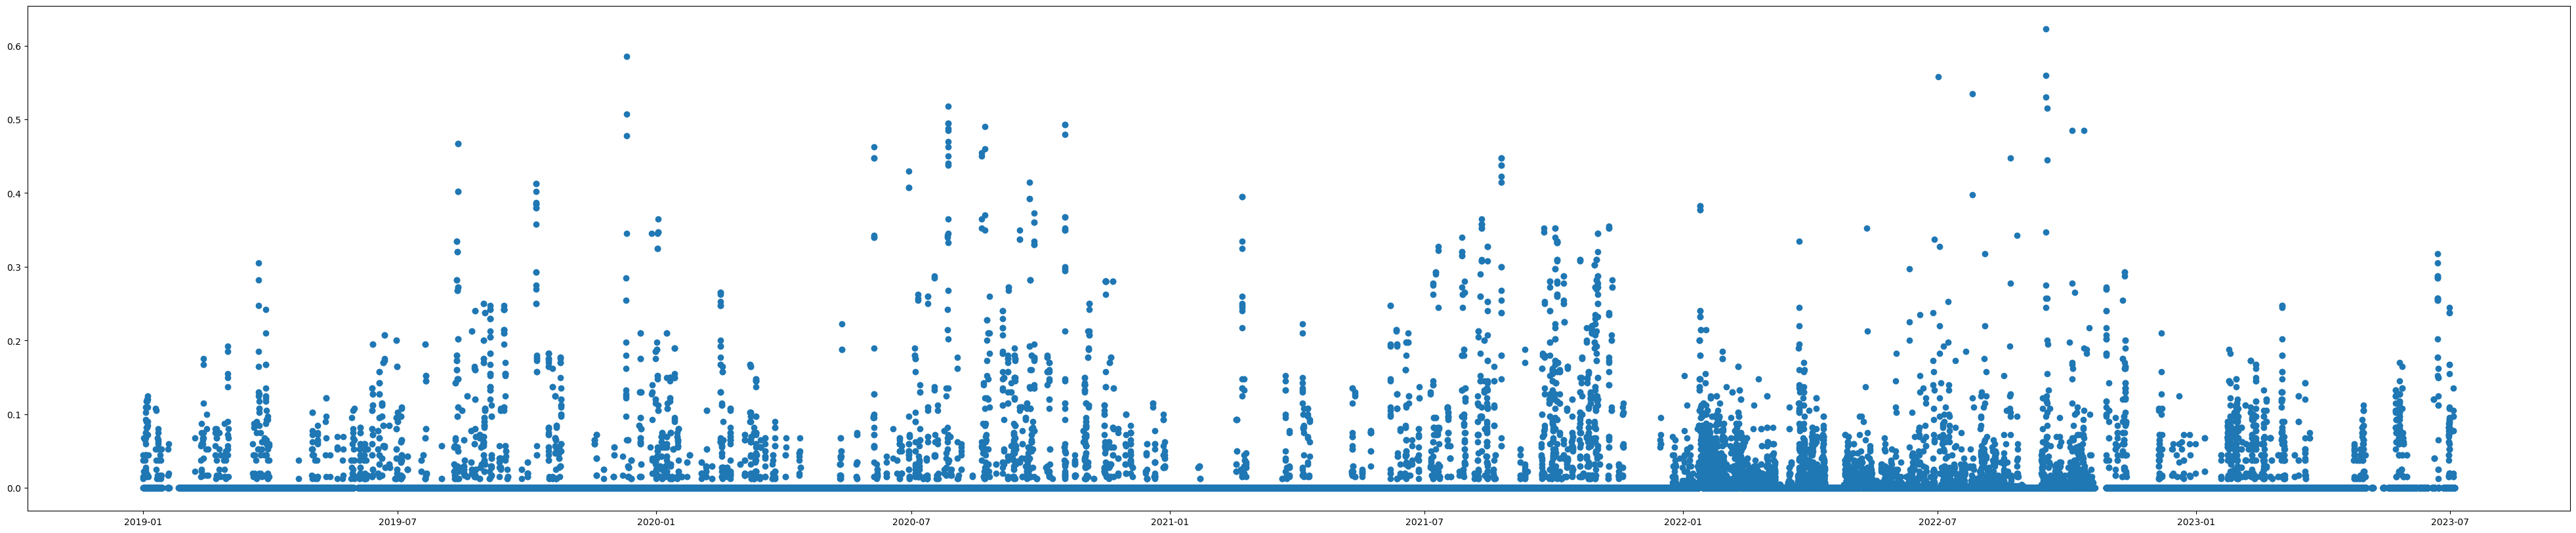

In [24]:
# Observe the outlier data

plt.figure(figsize=(50, 10))
plt.scatter(data_precip["date_forecast"], data_cloud["precip_5min:mm"])

### Model Setup


### Model Result


## Ensemble Model


In [210]:
# Define your target variable (ground truth)
# This should be a numpy array with shape (n_samples, )
target = (
    data[data.data_type.isin(["estimated", "observed"])]
    .pv_measurement.reset_index(drop=True)
    .to_numpy()
)

In [289]:
pred_data = pd.DataFrame()
for key in test_result.keys():
    if not test_result[key].empty:
        pred_data[key] = test_result[key][0]

pred_data

,general_catboost_mae,general_catboost_rmse,general_lightgbm
83045,-0.020705,0.391219,-0.567985
83046,-0.021921,-0.379679,-0.737496
83047,-0.000055,1.000165,-0.514508
83048,-0.022539,-4.722471,-0.703718
83049,-0.023199,-0.262833,-1.010278
...,...,...,...
85200,0.732188,-0.184722,-0.417115
85201,0.055493,1.989518,-1.250790
85202,7.361832,52.841269,28.951532
85203,1.503717,7.315372,3.750231


In [290]:
ensamble_data = pd.DataFrame()
for key in result.keys():
    if not result[key].empty:
        ensamble_data[key] = result[key][0]


ensamble_data

,general_catboost_mae,general_catboost_rmse,general_lightgbm
0,0.005483,-0.937258,-1.705526
1,0.000858,-0.404168,-0.490333
2,-0.004087,1.818214,0.201985
3,0.000085,3.179729,5.097704
4,0.004367,-0.371423,3.866576
...,...,...,...
83040,0.006106,0.831255,-0.087229
83041,-0.004866,-1.110484,0.012248
83042,-0.477621,5.275766,-0.289455
83043,-0.005503,-0.784950,-0.814597


In [308]:
ensamble_indices = data[
    data.data_type.isin(["observed", "estimated"])
    & data.date_forecast.dt.month.isin([5, 6, 7, 8])
].index

## H20 model


### Feature engineering


In [339]:
data_h2o = data.copy()

# one hot encoding the location feature
one_hot = pd.get_dummies(data_h2o["location"]).astype(int)
data_h2o = data_h2o.drop("location", axis=1)
data_h2o = pd.merge(data_h2o, one_hot, left_index=True, right_index=True)

# Drop columns that are not needed
drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    "pressure_50m:hPa",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "sun_azimuth:d",
]

data_h2o = data_h2o.drop(drop_cols, axis=1)

# Scaling train and test features

# deciding what coloumns to exclude from scaling
exclude = [
    "A",
    "B",
    "C",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]
# deciding what coloumns to scale
to_scale = [col for col in data_h2o.columns if col not in exclude]
min = data_h2o[data_h2o["data_type"].isin(["estimated", "observed"])][to_scale].min()
max = data_h2o[data_h2o["data_type"].isin(["estimated", "observed"])][to_scale].max()

# scaling
data_h2o[to_scale] = (data_h2o[to_scale] - min) / (max - min)

# scaling pv_measurement with a MinMaxScaler
h2o_scaler_pv = MinMaxScaler()
h2o_scaler_pv = h2o_scaler_pv.fit(
    data_h2o[data_h2o["data_type"].isin(["estimated", "observed"])][["pv_measurement"]]
)

data_h2o["pv_measurement"] = h2o_scaler_pv.transform(data_h2o[["pv_measurement"]])

# Create training and test data
train = (
    data_h2o[data_h2o["data_type"].isin(["observed", "estimated"])]
    .copy()
    .drop(columns=["data_type"])
)
test = data_h2o[data_h2o["data_type"].isin(["test"])].copy().drop(columns=["data_type"])

### Setup Model


In [376]:
h2o.init()

train = train.reset_index().drop(columns="index")

h2o_train = h2o.H2OFrame(train)
h2o_test = h2o.H2OFrame(test)

aml = H2OAutoML(
    max_models=20,
    seed=1,
    stopping_metric="MAE",
    sort_metric="MAE",
    stopping_tolerance=0.01,
)

aml.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train)
lb = aml.leaderboard
preds = aml.leader.predict(h2o_test)
lb.head(rows=lb.nrows)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.1" 2021-10-19; OpenJDK Runtime Environment Temurin-17.0.1+12 (build 17.0.1+12); OpenJDK 64-Bit Server VM Temurin-17.0.1+12 (build 17.0.1+12, mixed mode)
  Starting server from /Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/xd/z_ptq9v136q7kj9lf2f4sblh0000gn/T/tmpi3jfhewg
  JVM stdout: /var/folders/xd/z_ptq9v136q7kj9lf2f4sblh0000gn/T/tmpi3jfhewg/h2o_mathiasraa_started_from_python.out
  JVM stderr: /var/folders/xd/z_ptq9v136q7kj9lf2f4sblh0000gn/T/tmpi3jfhewg/h2o_mathiasraa_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_mathiasraa_6oe5nz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
00:48:00.825: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


model_id,mae,rmse,mse,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_1_20231026_04800_model_5,0.0150075,0.0457728,0.00209515,0.0337815,0.00209515
StackedEnsemble_AllModels_1_AutoML_1_20231026_04800,0.0151915,0.0446552,0.00199408,0.0329756,0.00199408
StackedEnsemble_BestOfFamily_1_AutoML_1_20231026_04800,0.0153751,0.0454934,0.00206965,0.0335943,0.00206965
GBM_4_AutoML_1_20231026_04800,0.0153798,0.0458564,0.00210281,0.0338761,0.00210281
DRF_1_AutoML_1_20231026_04800,0.0157517,0.0471594,0.00222401,0.0348562,0.00222401
GBM_3_AutoML_1_20231026_04800,0.0157548,0.0469563,0.0022049,0.0346793,0.0022049
GBM_1_AutoML_1_20231026_04800,0.0159291,0.0472415,0.00223176,0.0348807,0.00223176
GBM_grid_1_AutoML_1_20231026_04800_model_4,0.0159531,0.0458989,0.0021067,0.0339347,0.0021067
GBM_2_AutoML_1_20231026_04800,0.0160572,0.0474144,0.00224812,0.0350303,0.00224812
GBM_5_AutoML_1_20231026_04800,0.0165065,0.0481886,0.00232214,0.035609,0.00232214


### Results


In [377]:
prediction_df = preds.as_data_frame()
prediction_df_scaled = h2o_scaler_pv.inverse_transform(prediction_df)
prediction_df_scaled_df = pd.DataFrame(prediction_df_scaled)


# removing negative values and replacing with 0

resultframe = pd.DataFrame(columns=["id", "prediction"])
resultframe["prediction"] = prediction_df_scaled_df
resultframe["prediction"] = np.where(
    resultframe["prediction"] < 0, 0, resultframe["prediction"]
)
resultframe["id"] = range(len(resultframe))

In [378]:
new = resultframe.copy()
new["location"] = test["location"].reset_index(drop=True)

new.sort_values(by=["location", "id"]).head(50)

KeyError: 'location'

## AutoGluon


### Feature engineering


In [31]:
data_autogluon = data.copy()

# Drop columns that are not needed
drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    # "pressure_50m:hPa",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
    "date_calc",
    # "date_forecast",
    # "sun_azimuth:d",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    # Duplicate columns
    "prob_rime:p",
    "fresh_snow_1h:cm",
    "dew_or_rime:idx",
    "fresh_snow_3h:cm",
    "hour",
    "month",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
]

data_autogluon = data_autogluon.drop(drop_cols, axis=1)

test = (
    data_autogluon[data_autogluon["data_type"].isin(["test"])]
    .copy()
)
train, val = train_test_split(
    data_autogluon[data_autogluon["data_type"].isin(["observed", "estimated"])],
    test_size=0.02,
    random_state=42,
    shuffle=False
)

### Setup Model


#### Location A

In [27]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_A = tabular_predictor.fit(
    train_data=train[train.location == "A"],
    tuning_data=val[val.location == "A"],
    presets="best_quality",
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231027_111421"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231027_111421"
AutoGluon Version:  0.8.2
Python Version:     3.10.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   16.92 GB / 494.38 GB (3.4%)
Train Data Rows:    33508
Train Data Columns: 34
Tuning Data Rows:    553
Tuning Data Columns: 34
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 624.31911, 1159.82792)
	If 'regression' is not the correct problem_type, pl

#### Location B

In [28]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_B = tabular_predictor.fit(
    train_data=train[train.location == "B"],
    tuning_data=val[val.location == "B"],
    presets="best_quality",
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231027_112913"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231027_112913"
AutoGluon Version:  0.8.2
Python Version:     3.10.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   11.95 GB / 494.38 GB (2.4%)
Train Data Rows:    26554
Train Data Columns: 34
Tuning Data Rows:    554
Tuning Data Columns: 34
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 100.91695, 207.94996)
	If 'regression' is not the correct problem_type, ple

#### Location C

In [29]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_C = tabular_predictor.fit(
    train_data=train[train.location == "C"],
    tuning_data=val[val.location == "C"],
    presets="best_quality",
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231027_114227"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231027_114227"
AutoGluon Version:  0.8.2
Python Version:     3.10.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   8.97 GB / 494.38 GB (1.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    21322
Train Data Columns: 34
Tuning Data Rows:    554
Tuning Data Columns: 34
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, std

### Results


In [32]:
# Make predictions on the test dataset
test_data_nolab = test.drop(columns=["pv_measurement"])
y_pred_A = TabularPredictor.load("AutogluonModels/ag-20231027_111421").predict(test_data_nolab[test_data_nolab.location == "A"])
y_pred_B = TabularPredictor.load("AutogluonModels/ag-20231027_112913").predict(test_data_nolab[test_data_nolab.location == "B"])
y_pred_C = TabularPredictor.load("AutogluonModels/ag-20231027_114227").predict(test_data_nolab[test_data_nolab.location == "C"])

In [33]:
autogluon_result = pd.DataFrame(y_pred_A)
autogluon_result["location"] = "A"
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_B)], axis=0)
autogluon_result = autogluon_result.fillna("B")
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_C)], axis=0)
autogluon_result = autogluon_result.fillna("C")


96.46316658188833
27.28302266749593
24.530999475610628
Total:
49.4257295749983


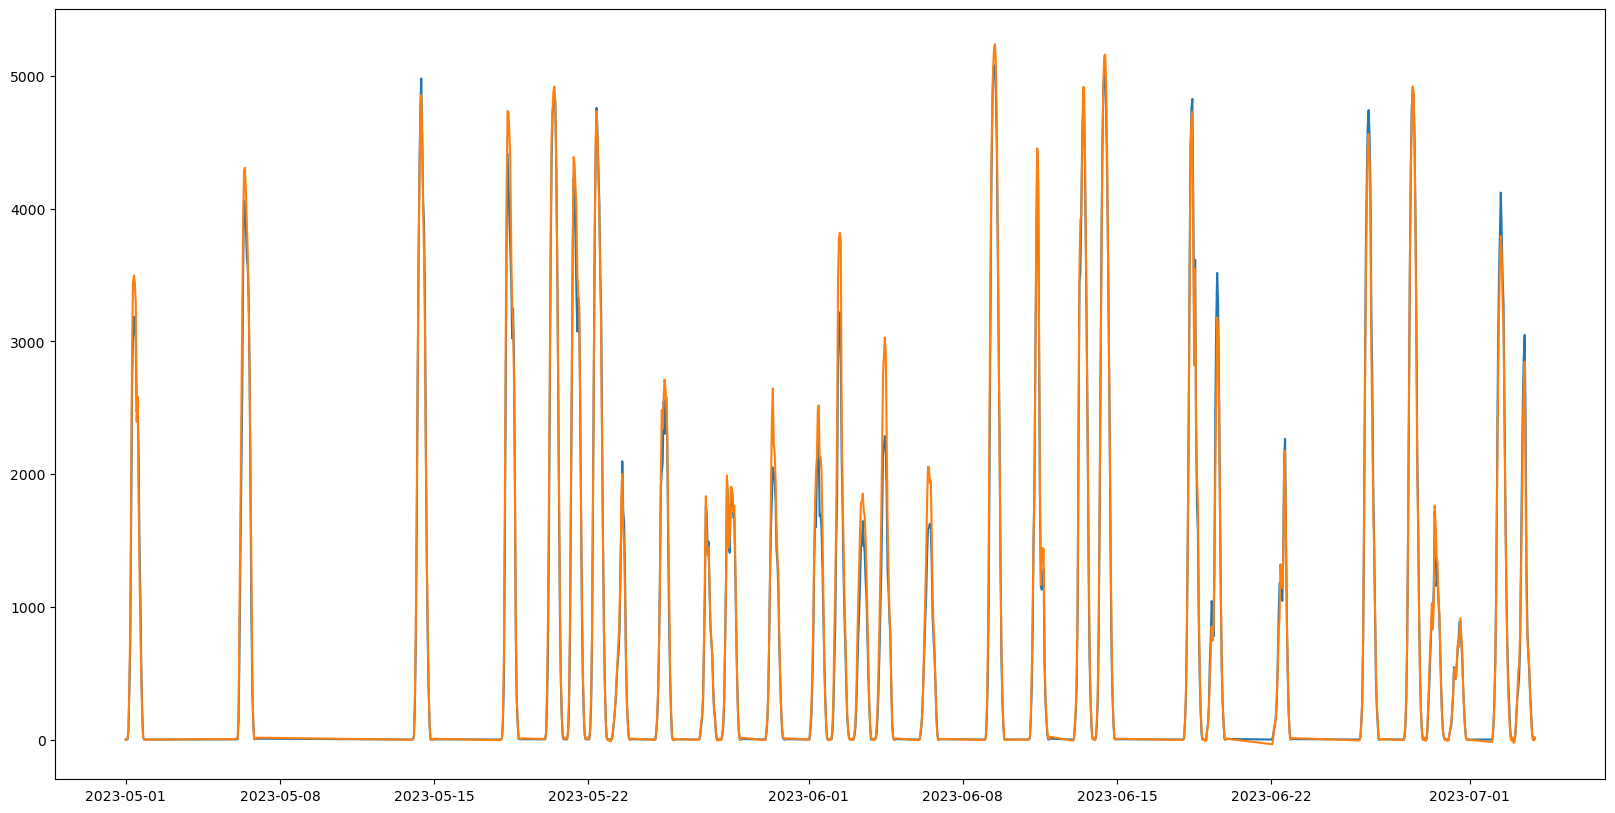

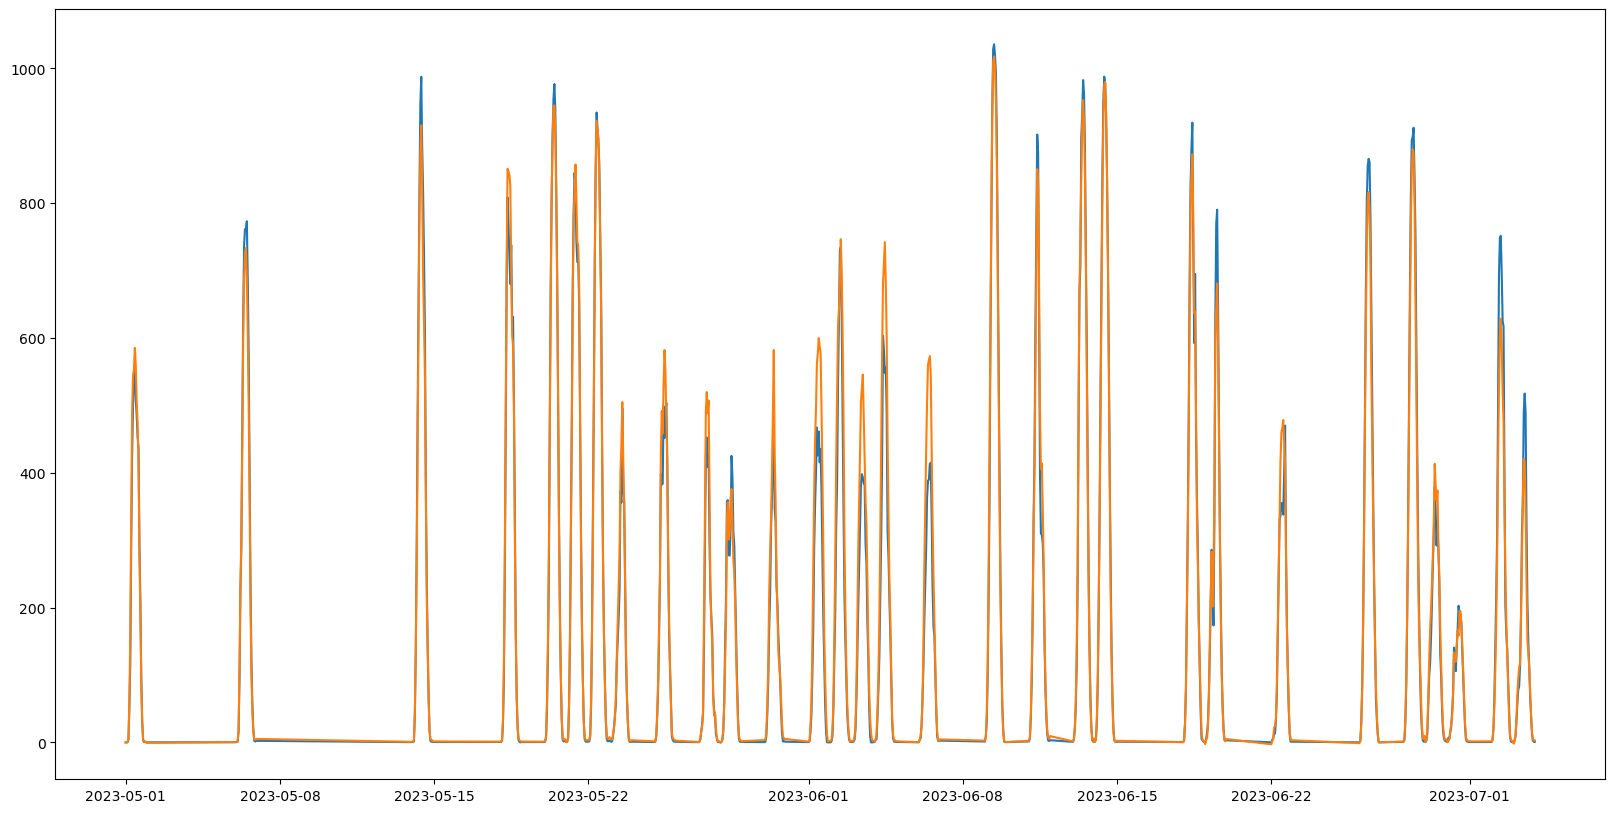

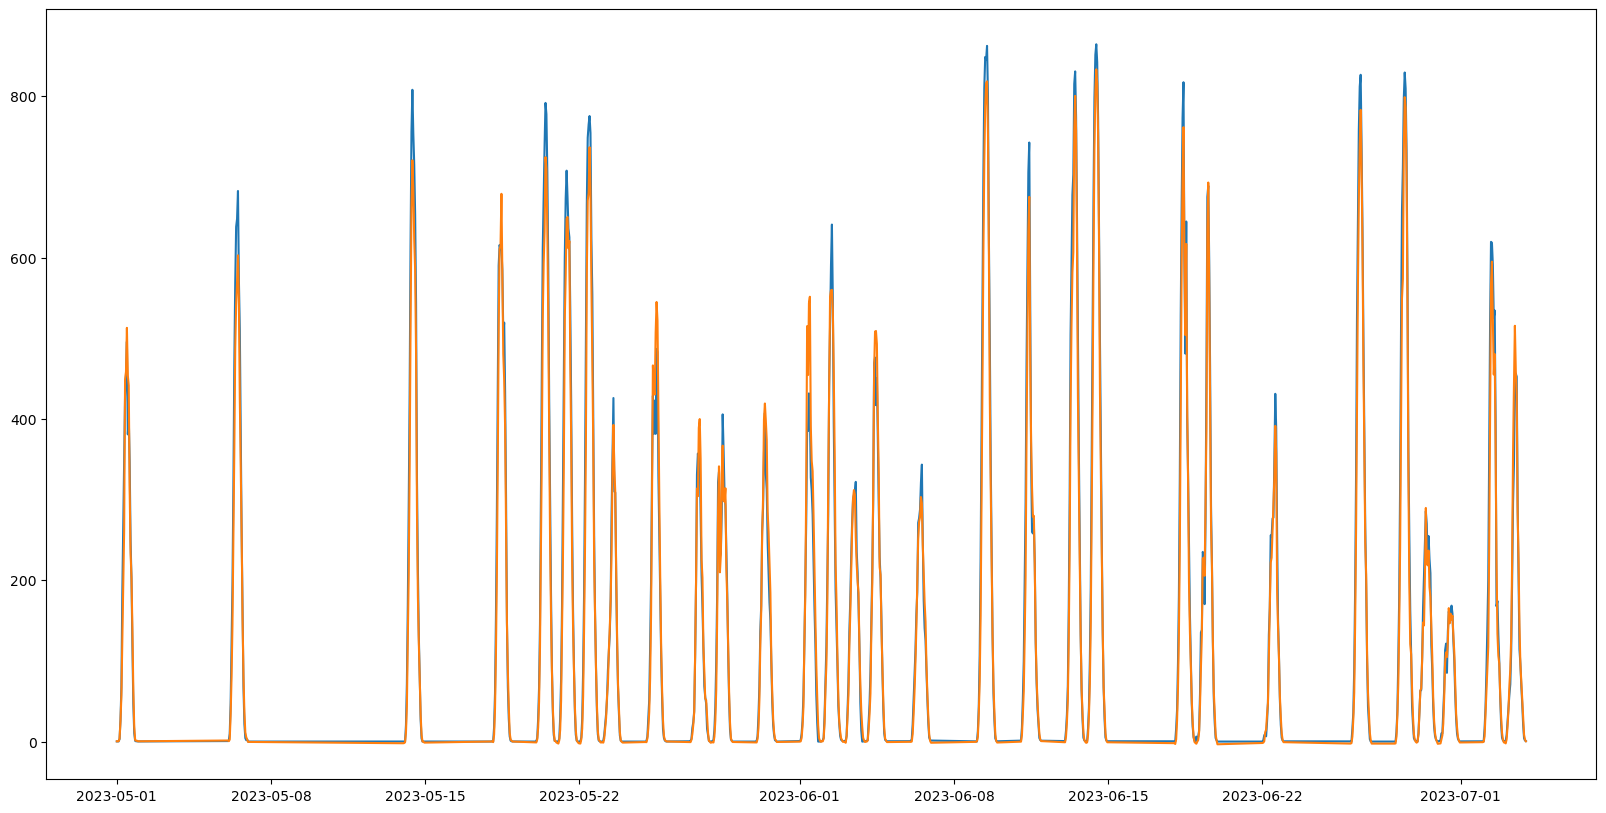

In [194]:
best_submission = pd.read_csv(
    "../data/results/2023-10-27 15:00:30.168954-ensamble.csv"
)
best_submission["location"] = autogluon_result["location"].to_numpy()


for location in ("A", "B", "C"):
    plt.figure(figsize=(20, 10))
    plt.plot(
        data[(data.data_type == "test") & (data.location == location)].sort_values(
            ["date_forecast", "location"]
        )["date_forecast"],
        best_submission[best_submission.location == location]["prediction"],
        label="Best submission",
    )
    plt.plot(
        data[(data.data_type == "test") & (data.location == location)].sort_values(
            ["date_forecast", "location"]
        )["date_forecast"],
        autogluon_result[autogluon_result.location == location]["pv_measurement"],
        label="New Model",
    )


    print(mean_absolute_error(
        best_submission[best_submission.location == location]["prediction"],
        autogluon_result[autogluon_result.location == location]["pv_measurement"],
    ))
print("Total:")
print(mean_absolute_error(
    best_submission["prediction"],
    autogluon_result["pv_measurement"],
))

In [35]:
last_autogluon = pd.read_csv(
    "../data/results/2023-10-23 20:20:14.497423-submission.csv"
)
last_autogluon["location"] = last_autogluon["location"].to_numpy()

KeyError: 'location'

# Submission

In [195]:
best_h2o = pd.read_csv("./sumbission_all_the_boys_1.csv")
best_catboost = pd.read_csv("../data/processed/catboost.csv")
best_lightgbm = test_result["general_lightgbm"]
best_lightgbm = best_lightgbm.rename(columns={0: "prediction"})
best_lightgbm["location"] = data[data.data_type == "test"]["location"].sort_values().to_numpy()
best_lightgbm["date_forecast"] = data[data.data_type == "test"]["date_forecast"].sort_values().to_numpy()
best_lightgbm = best_lightgbm.sort_values(["location", "date_forecast"])

print("MAE H2O:")
print(mean_absolute_error(best_submission["prediction"], best_h2o["prediction"]))
print("MAE Catboost:")
print(mean_absolute_error(best_submission["prediction"], best_catboost["prediction"]))
print("MAE LightGBM:")
print(mean_absolute_error(best_submission["prediction"], best_lightgbm["prediction"]))
print("MAE Autogluon:")
print(mean_absolute_error(best_submission["prediction"], autogluon_result["pv_measurement"]))

MAE H2O:
47.744201129215995
MAE Catboost:
36.38070145634008
MAE LightGBM:
59.92345888669282
MAE Autogluon:
49.4257295749983


In [200]:
lr_indices = best_h2o["prediction"].to_numpy() > 20

lr = LinearRegression(fit_intercept=False, positive=True)
lr.fit(
    pd.DataFrame(
        {
            "h2o": best_h2o["prediction"].to_numpy()[lr_indices],
            "catboost": best_catboost["prediction"].to_numpy()[lr_indices],
            # "lightgbm": best_lightgbm["prediction"].to_numpy()[lr_indices],
            "autogluon": autogluon_result["pv_measurement"].to_numpy()[lr_indices],
        }
    ),
    best_submission["prediction"][lr_indices],
)

weights = lr.coef_
# weights = [0.4*0.5, 0.5, 0, 0.6*0.5]

ensamble = (
    weights[0] * best_h2o["prediction"].to_numpy()
    + weights[1] * best_catboost["prediction"].to_numpy()
    # + weights[2] * best_lightgbm["prediction"].to_numpy()
    + weights[2] * autogluon_result["pv_measurement"].to_numpy()
)
ensamble = np.maximum(ensamble, 0)

print(weights)
print("Sum:", np.sum(weights))

[0.19999999 0.5        0.30000002]
Sum: 1.0000000115703307


In [197]:
print("MAE Ensamble:")
print(mean_absolute_error(best_submission["prediction"], ensamble))

MAE Ensamble:
6.84572981667281e-15


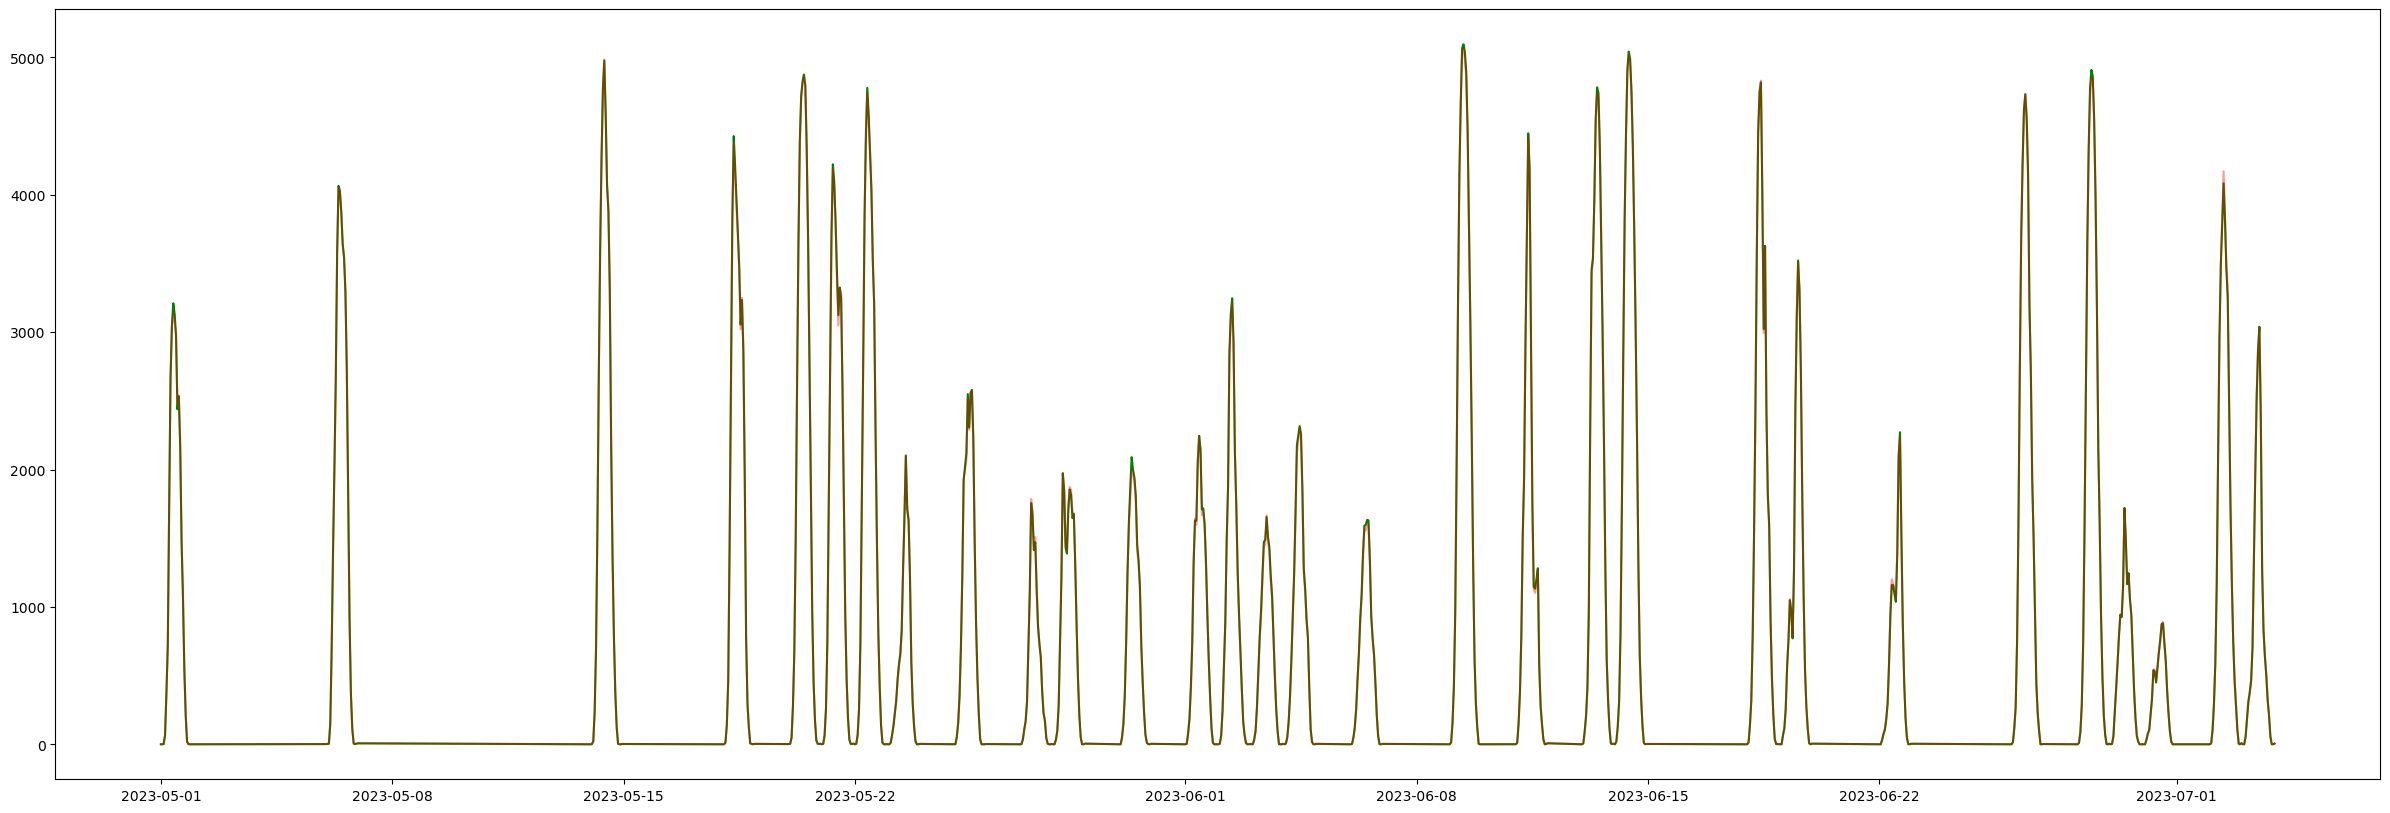

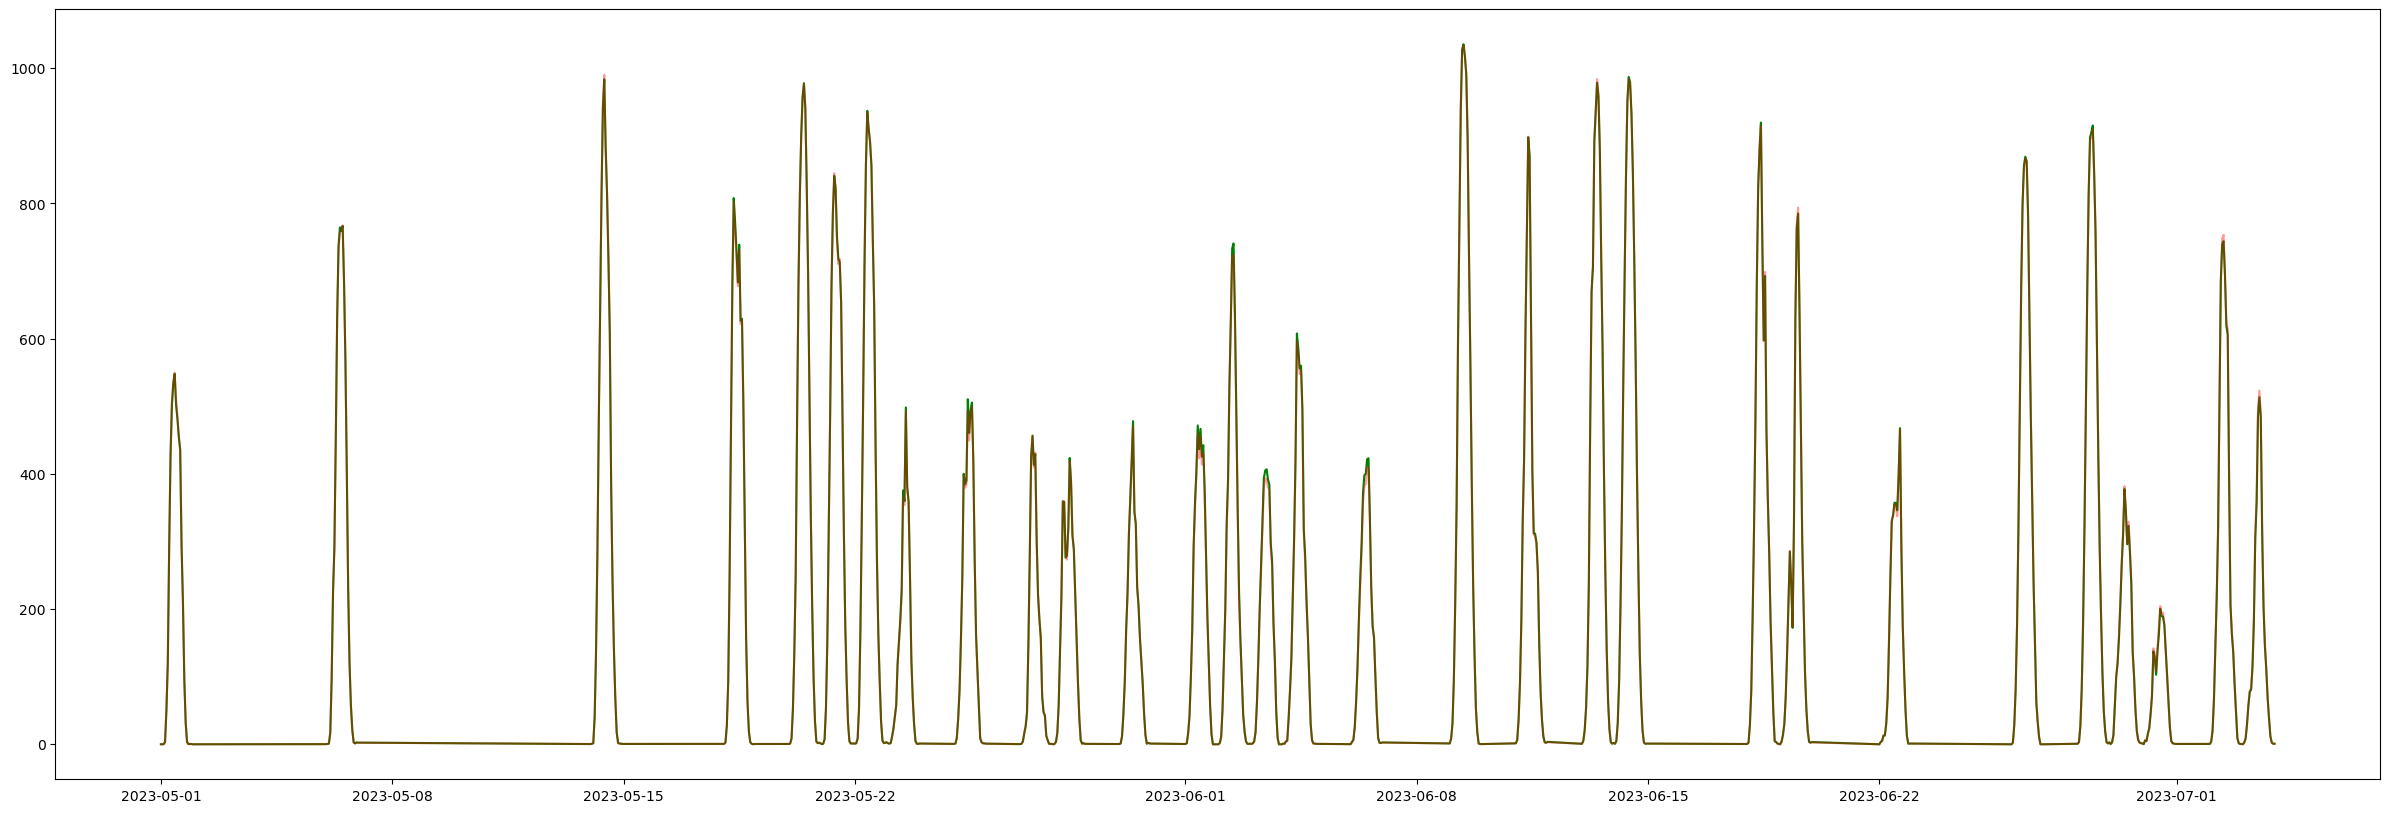

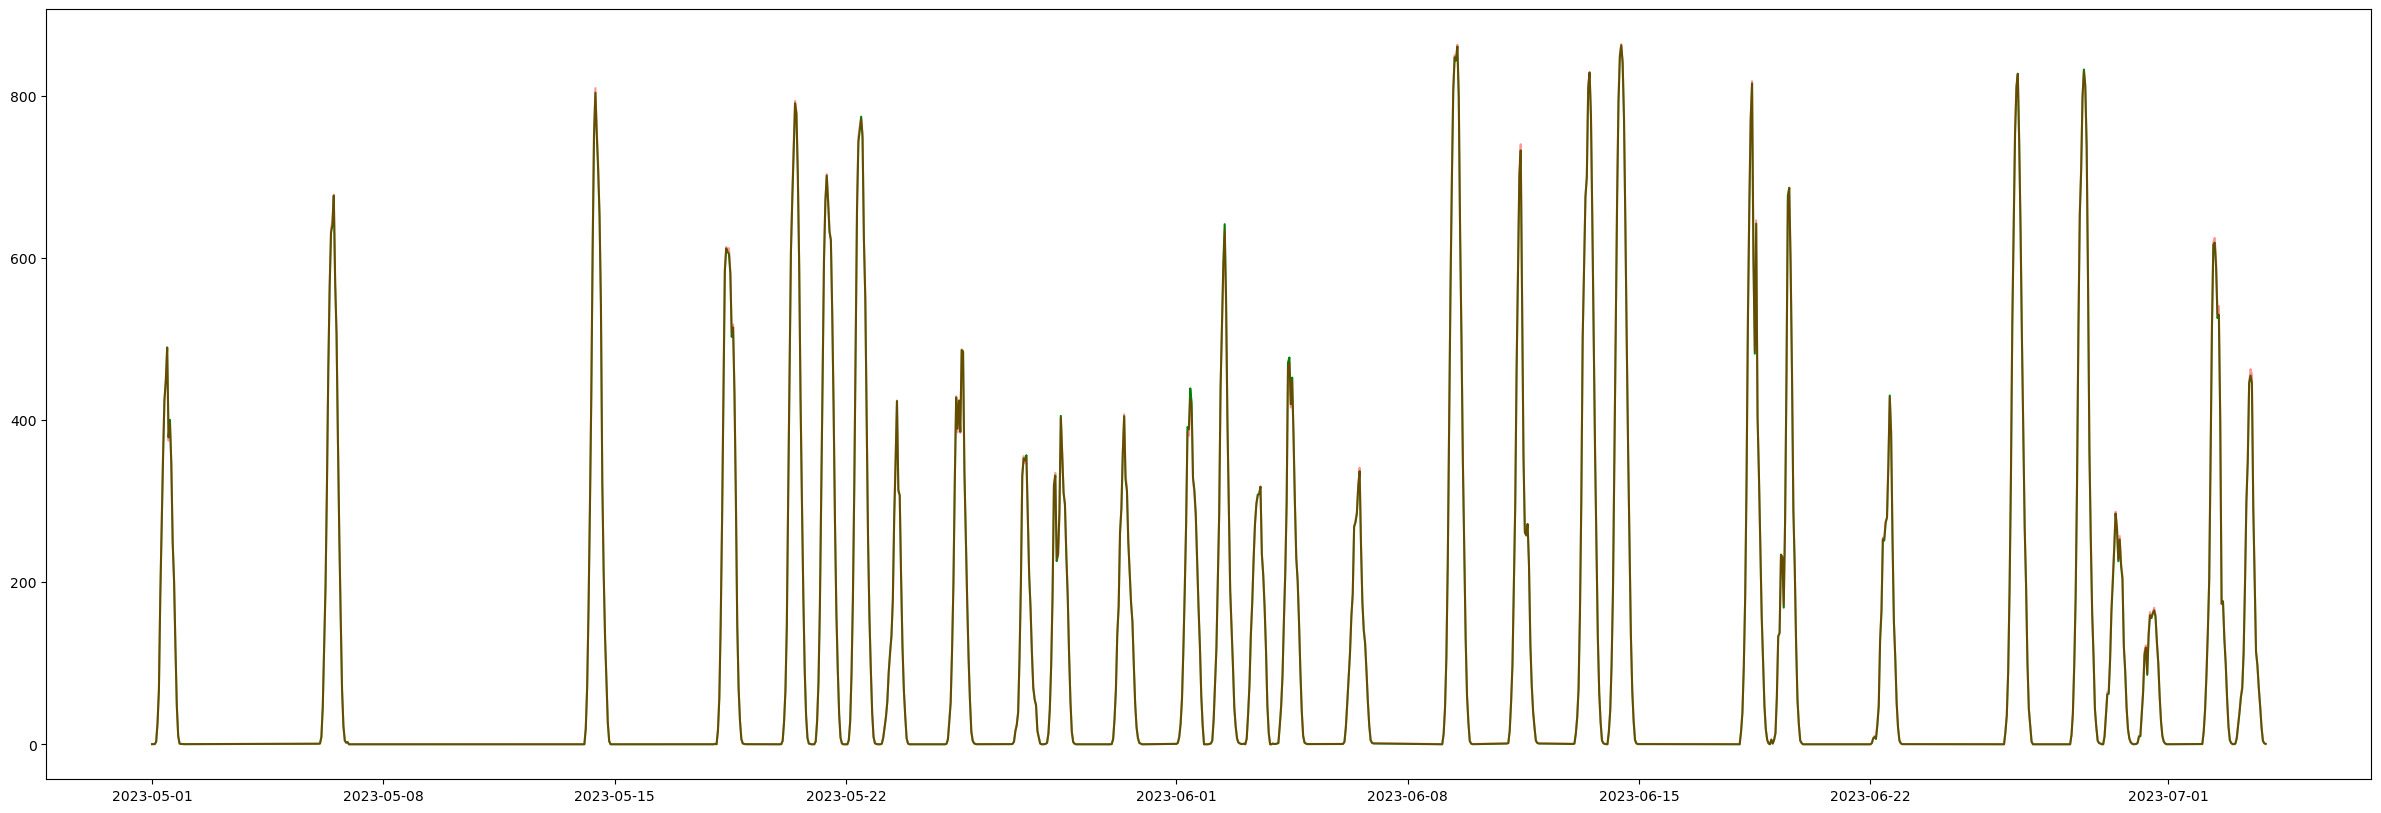

In [188]:
for location in ("A", "B", "C"):
    plot_ensamble = data[(data.data_type == "test")].sort_values(["location", "date_forecast"]).reset_index(drop=True)
    plot_ensamble = plot_ensamble[plot_ensamble.location == location].index
    plot_ensamble = ensamble[plot_ensamble]

    plt.figure(figsize=(30, 10))
    plt.plot(
        data[(data.data_type == "test") & (data.location == location)].sort_values(
            ["date_forecast", "location"]
        )["date_forecast"],
        best_submission[best_submission.location == location]["prediction"],
        label="Best submission",
        color="green"
    )
    plt.plot(
        data[(data.data_type == "test") & (data.location == location)].sort_values(
            ["date_forecast", "location"]
        )["date_forecast"],
        plot_ensamble,
        label="New Model",
        alpha=0.4,
        color="red"
    )

In [186]:
# np.sum(ensamble - np.where(
#     data[data.data_type.isin(["test"])].sort_values(["location", "date_forecast"])[
#         "is_day:idx"
#     ]
#     == 1,
#     ensamble,
#     0,
# )) / 2160

0.3924929205759316

In [189]:
output_df = pd.DataFrame(ensamble, columns=["prediction"])
output_df = output_df.reset_index(names="id")
output_df.to_csv("../data/results/"+ str(datetime.datetime.now()) + "-ensamble.csv", index=False)